<h2>1. Import the necessary library</h2>

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Dropout, Conv2DTranspose, Activation
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow import image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from scipy.spatial.distance import euclidean, cityblock, braycurtis, canberra
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

<h2>2. Load dataset</h2>

In [ ]:
# load & augment data train
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2,
                                  zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory('../../../Dataset/Batik Nitik 960 Retrieval/train',
                                                   target_size=(128, 128),
                                                   batch_size=32,
                                                   class_mode='categorical')
# load data validation
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory('../../../Dataset/Batik Nitik 960 Retrieval/val',
                                                   target_size=(128, 128),
                                                   batch_size=32,
                                                   class_mode='categorical')

# load data test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('../../../Dataset/Batik Nitik 960 Retrieval/test',
                                                   target_size=(128, 128),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 720 images belonging to 60 classes.
Found 120 images belonging to 60 classes.


Found 120 images belonging to 60 classes.


<h2>3. Define the model</h2>

In [ ]:
def build(width, height, depth, filters=(32, 64, 64, 128)):
    inputShape = (height, width, depth)

    # define the input to the encoder
    inputs = Input(shape=inputShape)
    x = inputs

    # define the encoder architecture
    x = Conv2D(32, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=2, padding='valid')(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=2, padding='valid')(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=2, padding='valid')(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=2, padding='valid')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D((2, 2), strides=2, padding='valid')(x)

    # define neural code
    neural_code = x

    # build the encoder model
    encoder = Model(inputs, neural_code, name="encoder")

    # start building the decoder model which will accept the
    # output of the encoder as its inputs
    x = neural_code

    # define the decoder architecture
    x = image.resize(x, size=(8, 8), method=image.ResizeMethod.NEAREST_NEIGHBOR)
    x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = image.resize(x, size=(16, 16), method=image.ResizeMethod.NEAREST_NEIGHBOR)
    x = Dropout(0.3)(x)
    x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = image.resize(x, size=(32, 32), method=image.ResizeMethod.NEAREST_NEIGHBOR)
    x = Dropout(0.3)(x)
    x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = image.resize(x, size=(64, 64), method=image.ResizeMethod.NEAREST_NEIGHBOR)
    x = Dropout(0.3)(x)
    x = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = image.resize(x, size=(128, 128), method=image.ResizeMethod.NEAREST_NEIGHBOR)
    x = Dropout(0.3)(x)

    # apply a single CONV_TRANSPOSE layer used to recover the original depth of the image
    x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)

    # build the decoder model
    decoder = Model(neural_code, outputs, name="decoder")

    # our autoencoder is the encoder + decoder
    autoencoder = Model(inputs, decoder(encoder(inputs)),
                        name="autoencoder")

    # return a 3-tuple of the encoder, decoder, and autoencoder
    return (encoder, decoder, autoencoder)

In [ ]:
encoder, decoder, autoencoder = build(128, 128, 3)

In [ ]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        (None, 4, 4, 128)         130176    
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       277635    
                                                                 
Total params: 407,811
Trainable params: 407,811
Non-trainable params: 0
_________________________________________________________________


<h2>4. Compile and train the model</h2>

In [ ]:
opt = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=opt, loss="mse")

In [ ]:
x_train, y_train = next(train_generator)
x_val, y_val = next(val_generator)

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=32,
                          validation_data=[x_val, x_val])

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0994 - val_loss: 0.1051
Epoch 2/100
1/1 [==============================] - 1s 520ms/step - loss: 0.0957 - val_loss: 0.1044
Epoch 3/100
1/1 [==============================] - 1s 518ms/step - loss: 0.0926 - val_loss: 0.1035
Epoch 4/100
1/1 [==============================] - 1s 565ms/step - loss: 0.0896 - val_loss: 0.1021
Epoch 5/100
1/1 [==============================] - 1s 549ms/step - loss: 0.0865 - val_loss: 0.1003
Epoch 6/100
1/1 [==============================] - 1s 544ms/step - loss: 0.0836 - val_loss: 0.0981
Epoch 7/100
1/1 [==============================] - 1s 553ms/step - loss: 0.0815 - val_loss: 0.0961
Epoch 8/100
1/1 [==============================] - 1s 544ms/step - loss: 0.0806 - val_loss: 0.0947
Epoch 9/100
1/1 [==============================] - 1s 518ms/step - loss: 0.0810 - val_loss: 0.0941
Epoch 10/100
1/1 [==============================] - 1s 552ms/step - loss: 0.0809 - val_loss: 0.0942
Epoch 11/100

<h2>5. Plot the training loss</h2>

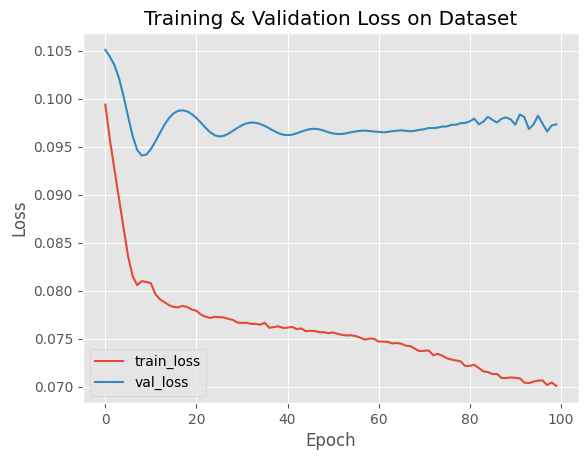

In [ ]:
N = np.arange(0, 100)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('plot/Loss.png', format='png')
plt.savefig('plot/Loss.svg', format='svg')

<h2>6. Save model for future used</h2>

In [ ]:
autoencoder.save('model/cae_model_baseline.h5')

<h2>7. Create indexing table from train images</h2>

In [ ]:
# load dataset
imagePaths = sorted(list(paths.list_images('../../../Dataset/Batik Nitik 960 Retrieval/train/')))
raw_image = []
data = []
labels = []

for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (128, 128))
    raw_image.append(image)
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

data = np.array(data)
labels = np.array(labels)

In [ ]:
# encoding query label
le = LabelEncoder()
labels = le.fit_transform(labels)

In [ ]:
cae_model = load_model('model/cae_model_baseline.h5')
encoder = cae_model.layers[1]

In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                       

In [ ]:
data = data/255.0

In [ ]:
features = encoder.predict(data)

23/23 [==============================] - 1s 35ms/step


In [ ]:
features.shape

(720, 4, 4, 128)

In [ ]:
# flatten the extracterd features
feature = []
for f in features:
    feature.append(f.flatten())
features = np.array(feature)
print(features.shape)

(720, 2048)


<h2>8. Load and extract feature of query image</h2>

In [ ]:
# load dataset
imagePaths = sorted(list(paths.list_images('../../../Dataset/Batik Nitik 960 Retrieval/test/')))
raw_query = []
query_data = []
query_labels = []

for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (128, 128))
    raw_query.append(image)
    image = img_to_array(image)
    query_data.append(image)

    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    query_labels.append(label)

query_data = np.array(query_data)
query_labels = np.array(query_labels)

In [ ]:
query_data = query_data/255.0
query_features = encoder.predict(query_data)
query_features.shape

4/4 [==============================] - 0s 30ms/step


(120, 4, 4, 128)

In [ ]:
# flatten the extracterd features
query_feature = []
for f in query_features:
    query_feature.append(f.flatten())
query_features = np.array(query_feature)
print(query_features.shape)

(120, 2048)


In [ ]:
# encoding query label
le = LabelEncoder()
query_labels = le.fit_transform(query_labels)

<h2>9. Measure the distance of query and train images</h2>

In [ ]:
# define sorted function to ranking result
def sort(res_list):
    return(sorted(res_list, key=lambda x: x[4]))

In [ ]:
# define function to calculate distance between query and data
def measure_dist(query_list, data_list, dist_method):
    result = []
    ind_query = 0
    for q in query_list:
        rank = []
        ind_data = 0
        for f in data_list:
            if dist_method == 'euclidean':
                dist = euclidean(q, f)
            elif dist_method == 'cityblock':
                dist = cityblock(q, f)
            elif dist_method == 'braycurtis':
                dist = braycurtis(q, f)
            elif dist_method == 'canberra':
                dist = canberra(q,f)
            rank.append([ind_query, query_labels[ind_query], ind_data, labels[ind_data], dist])
            ind_data += 1
        rank = sort(rank)
        result.append(rank[:12])  # jumlah yg di retrieve
        ind_query += 1
    result = np.array(result)
    return result

In [ ]:
# calculate using euclidean distance
result_euc = measure_dist(query_features, features, 'euclidean')

# calculate using cityblock distance
result_cit = measure_dist(query_features, features, 'cityblock')

# calculate using braycurtis distance
result_bra = measure_dist(query_features, features, 'braycurtis')

# calculate using canberra distance
result_can = measure_dist(query_features, features, 'canberra')

<h2>10. Calculate the precision and recall</h2>

In [ ]:
def calculate(x, num_of_retrieved, num_of_all_member):
    prec_list = []
    rec_list = []

    for i in range(x.shape[0]):
        relevant = 0
        for j in range(num_of_retrieved):
            if x[i][j][1]==x[i][j][3]:
                relevant +=1
        prec = relevant/num_of_retrieved
        rec = relevant/num_of_all_member
        prec_list.append(prec)
        rec_list.append(rec)

    precision = np.average(np.array(prec_list))
    recall = np.average(np.array(rec_list))

    return precision, recall

In [ ]:
# calculate recall and precision from retrieval result
n = 12 # jumlah yg di retrieve untuk menghitung precision dan recall
list_prec_euc = []
list_rec_euc = []
list_prec_cit = []
list_rec_cit = []
list_prec_bra = []
list_rec_bra = []
list_prec_can = []
list_rec_can = []

for k in range(n):
    prec_euc, rec_euc = calculate(result_euc, k+1, n)
    prec_cit, rec_cit = calculate(result_cit, k+1, n)
    prec_bra, rec_bra = calculate(result_bra, k+1, n)
    prec_can, rec_can = calculate(result_can, k+1, n)
    list_prec_euc.append(prec_euc)
    list_rec_euc.append(rec_euc)
    list_prec_cit.append(prec_cit)
    list_rec_cit.append(rec_cit)
    list_prec_bra.append(prec_bra)
    list_rec_bra.append(rec_bra)
    list_prec_can.append(prec_can)
    list_rec_can.append(rec_can)

In [ ]:
# calculate the average of precision and recall
avg_prec_euc = np.average(list_prec_euc)
avg_rec_euc = np.average(list_rec_euc)
avg_prec_cit = np.average(list_prec_cit)
avg_rec_cit = np.average(list_rec_cit)
avg_prec_bra = np.average(list_prec_bra)
avg_rec_bra = np.average(list_rec_bra)
avg_prec_can = np.average(list_prec_can)
avg_rec_can = np.average(list_rec_can)

In [ ]:
print("======= Avg. Precision =======")
print("Euclidean = ", avg_prec_euc)
print("Cityblock = ", avg_prec_cit)
print("Braycurtis = ", avg_prec_bra)
print("Canberra = ", avg_prec_can)

print("\n======= Avg. Recall =======")
print("Euclidean = ", avg_rec_euc)
print("Cityblock = ", avg_rec_cit)
print("Braycurtis = ", avg_rec_bra)
print("Canberra = ", avg_rec_can)

======= Avg. Precision =======
Euclidean =  0.9978254769921437
Cityblock =  0.9960032617845117
Braycurtis =  0.9983781014510184
Canberra =  0.9882857343274011

======= Avg. Recall =======
Euclidean =  0.5396412037037037
Cityblock =  0.5380787037037037
Braycurtis =  0.5402199074074073
Canberra =  0.5332175925925925


<h2>11. Plotting the precision and recall of all the measure method</h2>

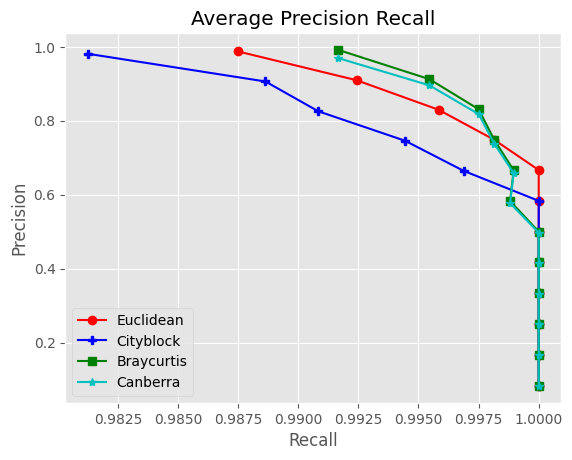

In [ ]:
plt.plot(list_prec_euc, list_rec_euc, 'ro-')
plt.plot(list_prec_cit, list_rec_cit, 'bP-')
plt.plot(list_prec_bra, list_rec_bra, 'gs-')
plt.plot(list_prec_bra, list_rec_can, 'c*-')
plt.title("Average Precision Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(["Euclidean", "Cityblock", "Braycurtis", "Canberra"])
plt.savefig('plot/APR.png', format='png')
plt.savefig('plot/APR.svg', format='svg')
plt.show()

<h2>12. Display the sample query and result</h2>

In [ ]:
# define dictionary for store label name
label_names = {"0" : "Brendi", "1" : "Cakar Ayam", "2" : "Ceplok Liring", "3" : "Cinde Wilis", "4" : "Gedhangan",
               "5" : "Jaya Kirana", "6" : "Jaya Kusuma", "7" : "Karawitan", "8" : "Kawung Nitik", "9" : "Kemukus",
               "10" : "Klampok Arum", "11" : "Kuncup Kanthil", "12" : "Manggar", "13" : "Mawur", "14" : "Rengganis",
               "15" : "Sarimulat", "16" : "Sekar Andong", "17" : "Sekar Arum Dalu", "18" : "Sekar Blimbing", "19" : "Sekar Cengkeh",
               "20" : "Sekar Dagan", "21" : "Sekar Dlima", "22" : "Sekar Duku", "23" : "Sekar Duren", "24" : "Sekar Gambir",
               "25" : "Sekar Gayam", "26" : "Sekar Gudhe", "27" : "Sekar Jagung", "28" : "Sekar Jali", "29" : "Sekar Jeruk",
               "30" : "Sekar Keben", "31" : "Sekar Kemuning", "32" : "Sekar Kenanga", "33" : "Sekar Kenikir", "34" : "Sekar Kentang",
               "35" : "Sekar Kepel", "36" : "Sekar Ketongkeng", "37" : "Sekar Lintang", "38" : "Sekar Manggis", "39" : "Sekar Menur",
               "40" : "Sekar Mindi", "41" : "Sekar Mlati", "42" : "Sekar Mrica", "43" : "Sekar Mundhu", "44" : "Sekar Nangka",
               "45" : "Sekar Pacar", "46" : "Sekar Pala", "47" : "Sekar Pijetan", "48" : "Sekar Pudhak", "49" : "Sekar Randu",
               "50" : "Sekar Sawo", "51" : "Sekar Soka", "52" : "Sekar Srengenge", "53" : "Sekar Sri Gading", "54" : "Sekar Tanjung",
               "55" : "Sekar Tebu", "56" : "Sri Taman", "57" : "Tanjung Gunung", "58" : "Truntum Kurung", "59" : "Wora Wari Numpuk",
               }

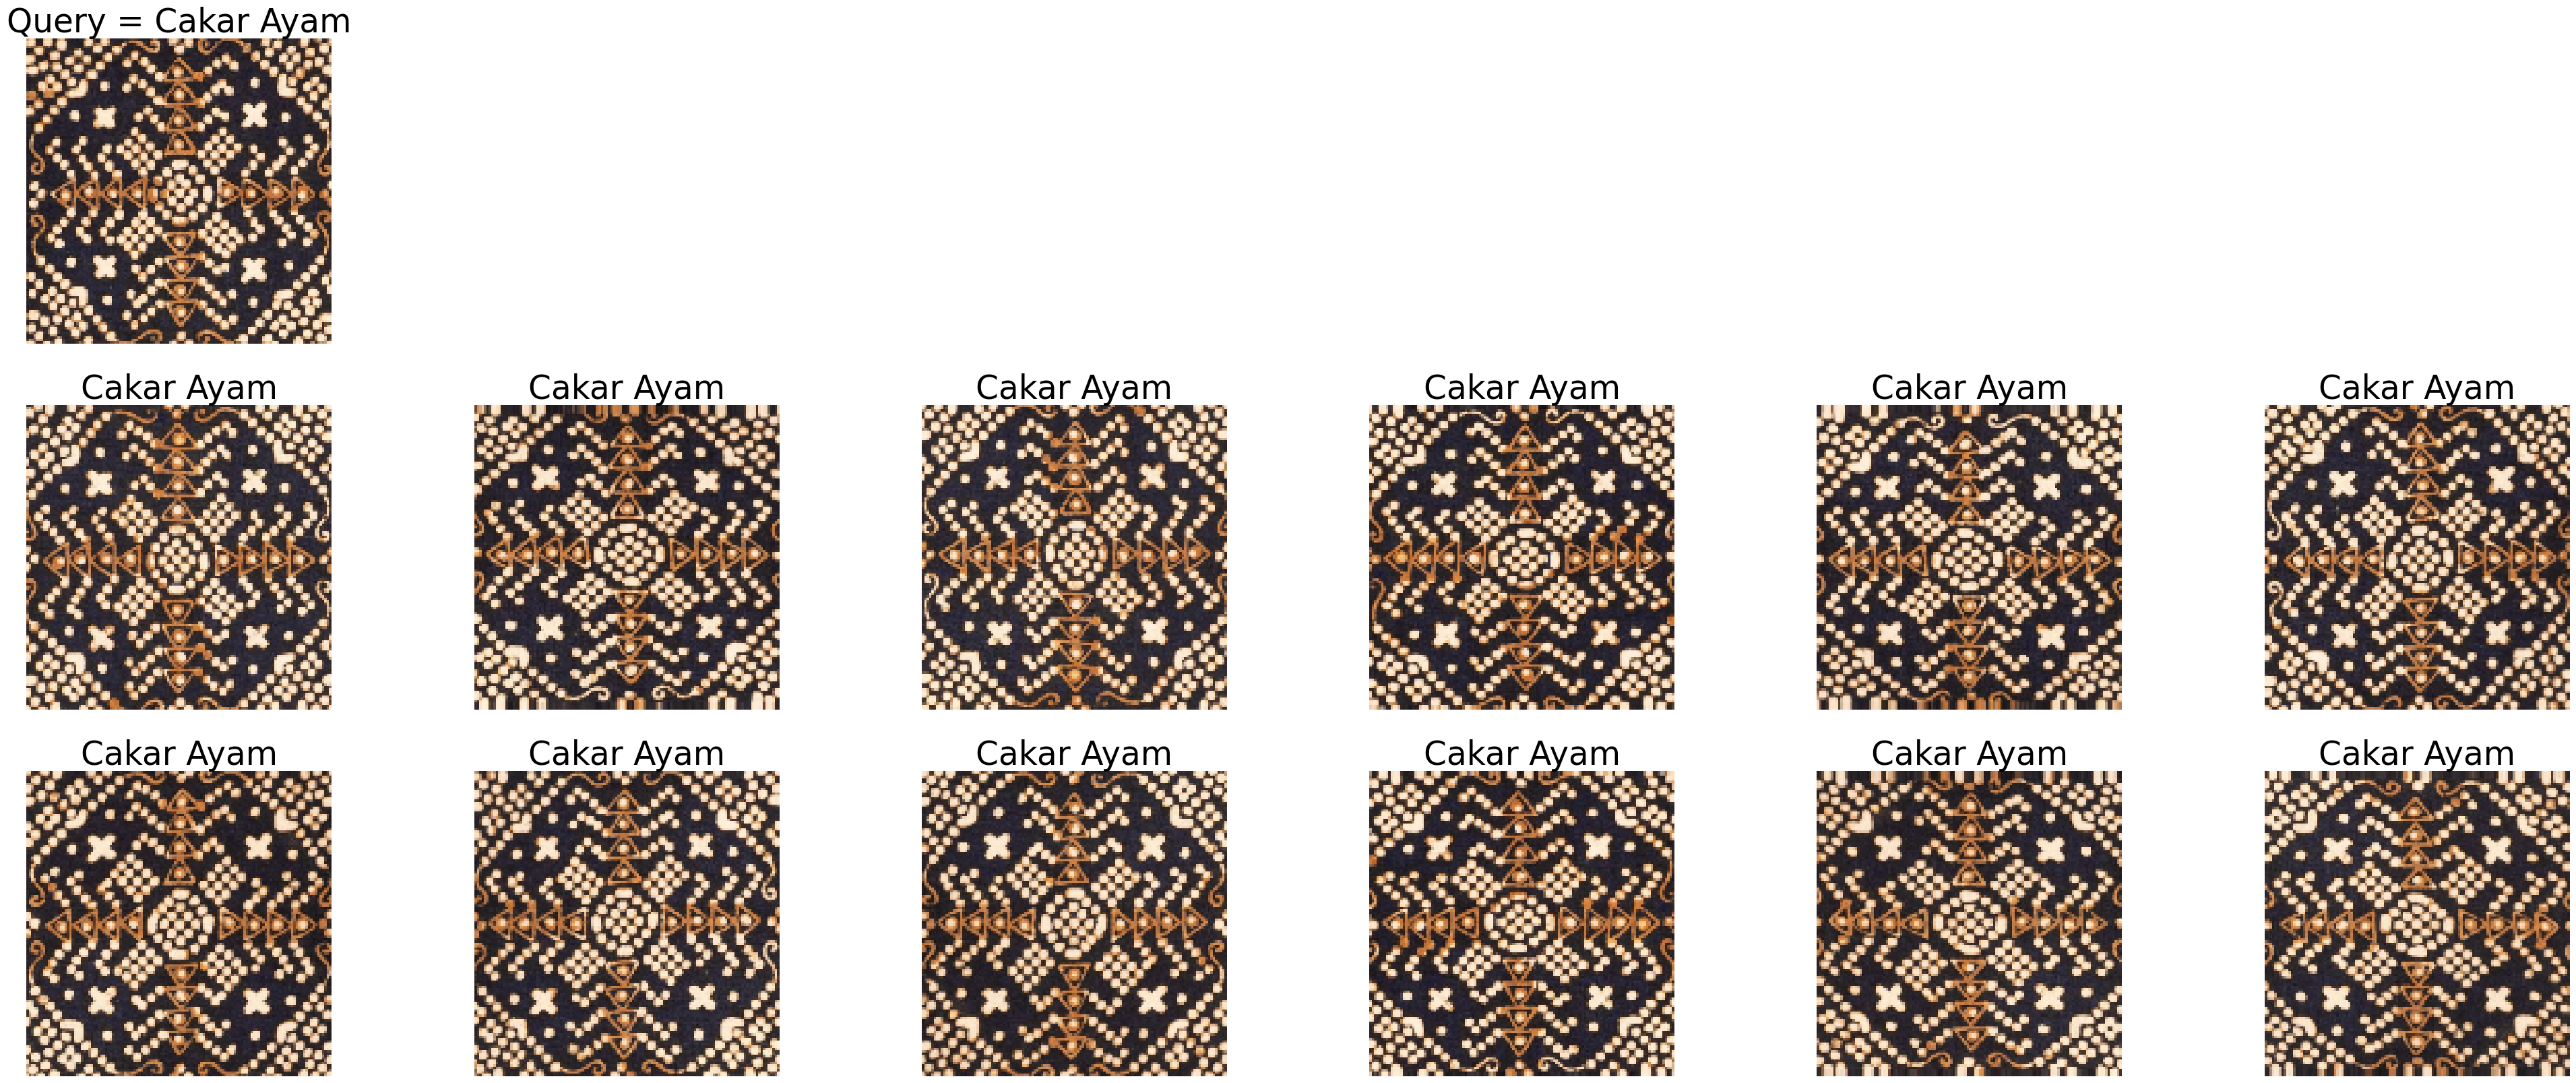

In [ ]:
fig = plt.figure(figsize=(50,20))
rows = 3
cols = 6

id_query = 2

query = raw_query[id_query]
fig.add_subplot(rows, cols, 1)
plt.imshow(cv2.cvtColor(query, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Query = "+label_names[str(query_labels[id_query])], fontsize=35)

i = 0
rank = 7
for res in result_can[id_query]:
    img_result = raw_image[int(res[2])]
    fig.add_subplot(rows, cols, rank)
    plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(label_names[str(int(res[3]))], fontsize=35)
    i += 1
    rank += 1
    plt.savefig('retrieval_result.png', format='png')
    plt.savefig('retrieval_result.svg', format='svg')

<h2>========== NEURAL CODE ==========</h2>

4/4 [==============================] - 0s 92ms/step


Text(0.5, 1.0, 'Fake')

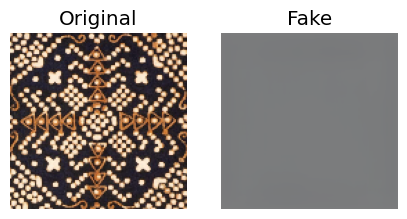

In [ ]:
fig = plt.figure(figsize=(5,5))
rows = 1
cols = 2

id = 3

query = query_data[id]
fig.add_subplot(rows, cols, 1)
plt.imshow(cv2.cvtColor(query, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original")

fake = autoencoder.predict(query_data)
fig.add_subplot(rows, cols, 2)
plt.imshow(cv2.cvtColor(fake[id], cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Fake")